# Evaluation Notebook

In [2]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from utils.tools import load_config

In [3]:
data = 'pvod'

config = load_config('config.yaml')
results_dir = config['eval']['results_path']
results_dir = os.path.join(results_dir, data)
result_files = os.listdir(results_dir)
# pickle files where training was performed on single dataset sequentially
sims = [f for f in result_files if (f.endswith('.pkl')) & ('cl' not in f) & ('fl' not in f)]
# pickle files where training was performed on concatenated datasets (centralized learning)
cl_sims = [f for f in result_files if 'cl' in f]
# pickle files for federated learning simulations
fl_sims = [f for f in result_files if 'fl' in f]
persistence_file = [f for f in result_files if 'persistence' in f][0]

In [ ]:
def concatenate_results(results_dir: str,
                        results: list,
                        index_cols: list,
                        get_skill: bool = False,
                        pers: pd.DataFrame = pd.DataFrame(),
                        sort_skill: bool = False) -> pd.DataFrame:
    indices = {}
    metrics = []
    if not results:
        print('No data found.')
        return None
    # initialize the dict list
    for col in index_cols:
        indices[col] = []
    for file in results:  # Iterate through all result files
        # Load the data
        with open(os.path.join(results_dir, file), 'rb') as f:
            pkl = pickle.load(f)
        df = pkl['evaluation']
        df.reset_index(inplace=True)
        if get_skill:
            df= pd.merge(df, pers[['RMSE', 'key', 'output_dim', 'freq']],
               on=['key', 'output_dim', 'freq'],
               how='left',
               suffixes=('', '_p'))
            df['Skill'] = 1 - df.RMSE / df.RMSE_p
            df.drop('RMSE_p', axis=1, inplace=True)
        for col in index_cols:
            indices[col].append(df[col].iloc[0])
        df.drop(index_cols, axis=1, inplace=True)
        df.drop('key', axis=1, inplace=True)
        metric = df.mean(axis=0)
        metrics.append(metric)
    df = pd.DataFrame(metrics, columns=metric.index)
    df_index = pd.DataFrame(indices)
    df = pd.concat([df, df_index], axis=1)
    df.sort_values(['output_dim', 'freq', 'Models'], inplace=True)
    if sort_skill:
        df.sort_values(['Skill'], ascending=False, inplace=True)
    return df

def read_sim(results_dir, sim):
    try:
        with open(os.path.join(results_dir, sim), 'rb') as f:
            sim_results = pickle.load(f)
    except:
        sim_results = None
    return sim_results

In [5]:
pers = pd.read_csv(os.path.join(results_dir, persistence_file))

Local simulation analysis - 1 dataset : 1 model 

In [6]:
index_cols = ['Models', 'output_dim', 'freq', 't_0']
df_sep = concatenate_results(results_dir=results_dir, results=sims, index_cols=index_cols)
df_sep[['R^2', 'RMSE', 'MAE', 'Skill', 'Models']].round(4).set_index('Models')

I0000 00:00:1748939048.229131 1375615 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46209 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1748939048.232087 1375615 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46683 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6
I0000 00:00:1748939048.234760 1375615 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46731 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6
I0000 00:00:1748939048.237394 1375615 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46717 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:61:00.0, compute capability: 8.6
I0000 00:00:1748939048.240031 1375615 gpu_device.cc:2022] Created device /job:localh

,R^2,RMSE,MAE,Skill
Models,,,,
tcn-gru,0.8103,0.117,0.0765,0.241


Federated simulation analysis - N datasets : 1 model

In [7]:
index_cols = ['Models', 'output_dim', 'freq', 't_0', 'strategy', 'gti', 'personalization']
df_fl = concatenate_results(results_dir=results_dir,
                            results=fl_sims,
                            index_cols=index_cols)
df_fl[['R^2', 'RMSE', 'MAE', 'Skill', 'Models', 'strategy', 'gti', 'personalization']].round(4).set_index('Models')

,R^2,RMSE,MAE,Skill,strategy,gti,personalization
Models,,,,,,,
tcn-gru,0.9137,0.0760,0.0422,0.5279,fedavg,True,False
tcn-gru,0.9436,0.0623,0.0356,0.5891,fedavg,True,True
tcn-gru,0.8809,0.0903,0.0512,0.4503,fedavg,False,False
tcn-gru,0.9175,0.0769,0.0433,0.5130,fedavg,False,True
tcn-gru,0.9596,0.0523,0.0290,0.6579,fedadam,True,True


Centralized simulation analysis - N datasets : 1 model

In [8]:
index_cols = ['Models', 'output_dim', 'freq', 't_0']
df_cl = concatenate_results(results_dir=results_dir,
                             get_skill=True,
                             pers=pers,
                             results=cl_sims,
                             index_cols=index_cols)
df_cl[['R^2', 'RMSE', 'MAE', 'Skill', 'Models']].round(4).set_index('Models')

,R^2,RMSE,MAE,Skill
Models,,,,
tcn-gru,0.965,0.0488,0.0249,0.6915


Individual simulation analysis

In [9]:
model = 'tcn-gru'
output_dim = 48
freq = '1h'
strategy = 'fedadam'
gti = '_gti_pers'

sim = f'd-{data}_m-{model}_out-{output_dim}_freq-{freq}.pkl'
cl_sim = f'cl_d-{data}_m-{model}_out-48_freq-{freq}.pkl'
fl_sim = f'fl_a-{strategy}_d-{data}_m-{model}_out-{output_dim}_freq-{freq}{gti}.pkl'

In [10]:
sim_results = read_sim(results_dir, sim)
cl_results = read_sim(results_dir, cl_sim)
fl_results = read_sim(results_dir, fl_sim)

In [11]:
sim_results['evaluation'][['R^2', 'RMSE', 'MAE', 'Skill', 'key']].round(4).set_index('key')

,R^2,RMSE,MAE,Skill
key,,,,
station00.csv,0.8427,0.0909,0.0526,0.3308
station01.csv,0.8674,0.1106,0.0688,0.2845
station02.csv,0.8407,0.1026,0.0625,0.3002
station04.csv,0.7422,0.1950,0.1382,0.2011
station06.csv,0.7557,0.1050,0.0687,0.0398
station07.csv,0.7707,0.1181,0.0765,0.1849
station08.csv,0.8524,0.0968,0.0683,0.3455


In [9]:
fl_results['evaluation'][['R^2', 'RMSE', 'MAE', 'Skill', 'key']].round(4).set_index('key')

,R^2,RMSE,MAE,Skill
key,,,,
station00.csv,0.9250,0.0628,0.0284,0.5379
station01.csv,0.9736,0.0493,0.0273,0.6810
station02.csv,0.9810,0.0354,0.0208,0.7585
station04.csv,0.9531,0.0832,0.0503,0.6593
station06.csv,0.9536,0.0458,0.0256,0.5814
station07.csv,0.9485,0.0560,0.0313,0.6136
station08.csv,0.9824,0.0335,0.0196,0.7737


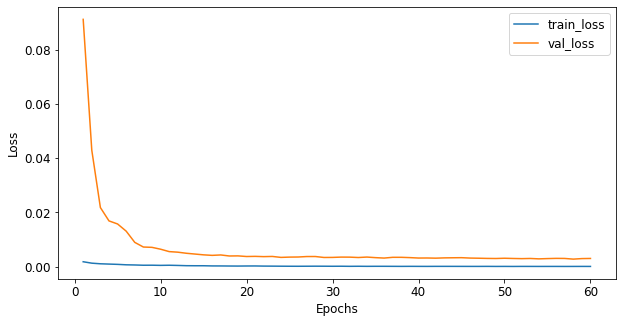

In [30]:
fontsize = 12

fig = plt.figure(figsize=(10, 5))

plt.plot(fl_results['history']['metrics_aggregated']['train_loss'], label='train_loss')
plt.plot(fl_results['history']['metrics_aggregated']['eval_loss'], label='val_loss')
plt.xlabel('Epochs', size=fontsize)
plt.ylabel('Loss', size=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [13]:
cl_results['evaluation'][['R^2', 'RMSE', 'MAE', 'Skill', 'key']].round(4).set_index('key')

,R^2,RMSE,MAE,Skill
key,,,,
station00.csv,0.9292,0.0610,0.0220,0.5511
station01.csv,0.9839,0.0386,0.0201,0.7504
station02.csv,0.9801,0.0363,0.0195,0.7526
station04.csv,0.9399,0.0941,0.0551,0.6143
station06.csv,0.9747,0.0338,0.0181,0.6908
station07.csv,0.9602,0.0492,0.0236,0.6605
station08.csv,0.9870,0.0288,0.0160,0.8056


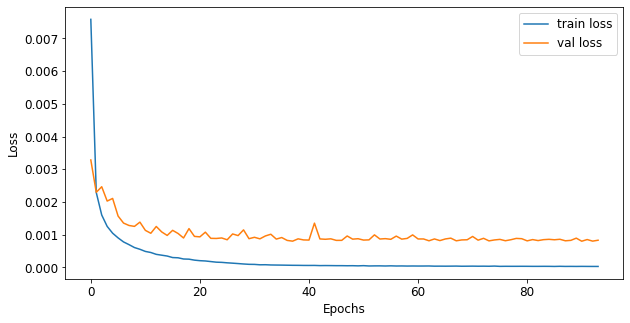

In [31]:
fig = plt.figure(figsize=(10, 5))

plt.plot(cl_results['history']['loss'], label='train loss')
plt.plot(cl_results['history']['val_loss'], label='val loss')
plt.xlabel('Epochs', size=fontsize)
plt.ylabel('Loss', size=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()